# Human Image Background Remover

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

## DATASET

In [4]:
def load_image(x):
    bytes = tf.io.read_file(x)
    img = tf.io.decode_png(bytes)
    return img

In [5]:
def load_mask_image(x):
    bytes = tf.io.read_file(x)
    img = tf.io.decode_png(bytes,channels=1)
    return img

In [6]:
images = tf.data.Dataset.list_files('./drive/MyDrive/dataset/images/*.png', shuffle=False)
images = images.map(load_image)
images = images.map(lambda x: tf.image.resize(x, (256,256)))
images = images.map(lambda x: x/255)

In [7]:
masks = tf.data.Dataset.list_files('./drive/MyDrive/dataset/masks/*.png', shuffle=False)
masks = masks.map(load_mask_image)
masks = masks.map(lambda x: tf.image.resize(x, (256,256)))
masks = masks.map(lambda x: x/255)

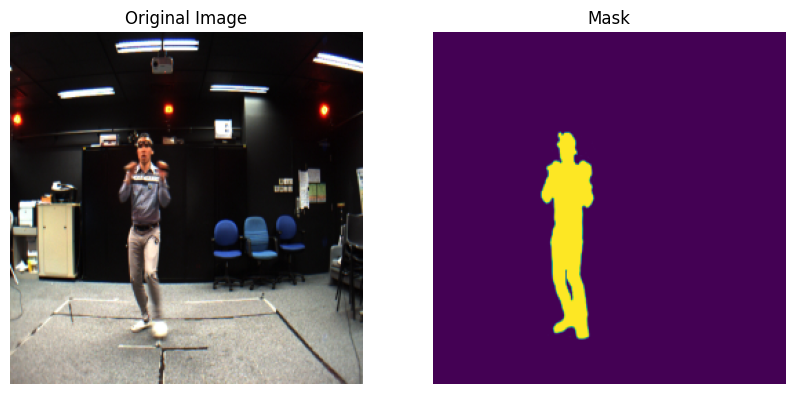

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(images.as_numpy_iterator().next())
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(masks.as_numpy_iterator().next())
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()


In [9]:
data = tf.data.Dataset.zip((images, masks))

In [10]:
data = data.shuffle(buffer_size=1000)
data = data.batch(32)
data = data.prefetch(tf.data.AUTOTUNE)

In [13]:
data.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

## Model

In [35]:
def u_net_model():

    input = layers.Input(shape=(256,256,3))

    # Down_Block 1
    conv1_1 = layers.Conv2D(64,3,activation="relu",padding="same")(input)
    conv1_2 = layers.Conv2D(64,3,activation="relu",padding="same")(conv1_1)
    pool_1 = layers.MaxPooling2D(2)(conv1_2)

    # Down_Block 2
    conv2_1 = layers.Conv2D(128,3,activation="relu",padding="same")(pool_1)
    conv2_2 = layers.Conv2D(128,3,activation="relu",padding="same")(conv2_1)
    pool_2 = layers.MaxPooling2D(2)(conv2_2)

    # Down_Block 3
    conv3_1 = layers.Conv2D(256,3,activation="relu",padding="same")(pool_2)
    conv3_2 = layers.Conv2D(256,3,activation="relu",padding="same")(conv3_1)
    pool_3 = layers.MaxPooling2D(2)(conv3_2)

    # BottleNeck
    conv4_1 = layers.Conv2D(512,3,activation="relu",padding="same")(pool_3)
    conv4_2 = layers.Conv2D(512,3,activation="relu",padding="same")(conv4_1)

    # Up_block 1
    upconv_1 = layers.Conv2DTranspose(256,2,strides=2,padding="same")(conv4_2)
    concat_1 = layers.concatenate([conv3_2,upconv_1])
    upconv1_1 = layers.Conv2D(256,3,activation="relu",padding="same")(concat_1)
    upconv1_2 = layers.Conv2D(256,3,activation="relu",padding="same")(upconv1_1)

    # Up_block 2
    upconv_2 = layers.Conv2DTranspose(128,2,strides=2,padding="same")(upconv1_2)
    concat_2 = layers.concatenate([conv2_2,upconv_2])
    upconv2_1 = layers.Conv2D(128,3,activation="relu",padding="same")(concat_2)
    upconv2_2 = layers.Conv2D(128,3,activation="relu",padding="same")(upconv2_1)

    # Up_block 3
    upconv_3 = layers.Conv2DTranspose(64,2,strides=2,padding="same")(upconv2_2)
    concat_3 = layers.concatenate([conv1_2,upconv_3])
    upconv3_1 = layers.Conv2D(64,3,activation="relu",padding="same")(concat_3)
    upconv3_2 = layers.Conv2D(64,3,activation="relu",padding="same")(upconv3_1)

    # Output
    output = layers.Conv2D(1, (1,1), activation='sigmoid')(upconv3_2)

    model = models.Model(input,output)

    return model

In [36]:
model = u_net_model()

In [37]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 128)    │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 256)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 64, 64, 256)    │        524,544 │ conv2d_22[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 64, 512)    │              0 │ conv2d_20[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │      1,179,904 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4   

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

## Training

In [42]:
import os

In [43]:
class SaveModelEvery5Epochs(tf.keras.callbacks.Callback):
    def __init__(self, save_dir="models"):
        super(SaveModelEvery5Epochs, self).__init__()
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:  # Save every 5 epochs
            save_path = os.path.join(self.save_dir, f"model_epoch_{epoch+1}.h5")
            self.model.save(save_path)
            print(f"\n Model saved at {save_path}")

In [45]:
history = model.fit(data,epochs=50,callbacks=[SaveModelEvery5Epochs()])

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8479 - loss: 0.4238
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9475 - loss: 0.1503
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9493 - loss: 0.1156
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9528 - loss: 0.0965
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9517 - loss: 0.0985


 Model saved at models/model_epoch_5.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9517 - loss: 0.0984
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9566 - loss: 0.0813
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9580 - loss: 0.0792
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9586 - loss: 0.0828
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9565 - loss: 0.0777
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9574 - loss: 0.0774


 Model saved at models/model_epoch_10.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9574 - loss: 0.0774
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9605 - loss: 0.0723
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9608 - loss: 0.0695
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9619 - loss: 0.0695
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9615 - loss: 0.0671
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9622 - loss: 0.0659


 Model saved at models/model_epoch_15.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9621 - loss: 0.0660
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9603 - loss: 0.0736
Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9595 - loss: 0.0664
Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9637 - loss: 0.0640
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9621 - loss: 0.0653
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9614 - loss: 0.0648


 Model saved at models/model_epoch_20.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9614 - loss: 0.0648
Epoch 21/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9639 - loss: 0.0615
Epoch 22/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9637 - loss: 0.0588
Epoch 23/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9624 - loss: 0.0585
Epoch 24/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9620 - loss: 0.0581
Epoch 25/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9640 - loss: 0.0581


 Model saved at models/model_epoch_25.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9640 - loss: 0.0582
Epoch 26/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9652 - loss: 0.0557
Epoch 27/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9666 - loss: 0.0546
Epoch 28/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9644 - loss: 0.0554
Epoch 29/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9676 - loss: 0.0509
Epoch 30/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9671 - loss: 0.0507


 Model saved at models/model_epoch_30.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9671 - loss: 0.0507
Epoch 31/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9647 - loss: 0.0545
Epoch 32/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9692 - loss: 0.0499
Epoch 33/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9650 - loss: 0.0475
Epoch 34/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9672 - loss: 0.0484
Epoch 35/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9690 - loss: 0.0446


 Model saved at models/model_epoch_35.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9690 - loss: 0.0446
Epoch 36/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9688 - loss: 0.0437
Epoch 37/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9717 - loss: 0.0406
Epoch 38/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9722 - loss: 0.0388
Epoch 39/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9725 - loss: 0.0367
Epoch 40/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9694 - loss: 0.0388


 Model saved at models/model_epoch_40.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9694 - loss: 0.0388
Epoch 41/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9703 - loss: 0.0380
Epoch 42/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9715 - loss: 0.0352
Epoch 43/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9733 - loss: 0.0343
Epoch 44/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9723 - loss: 0.0336
Epoch 45/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9723 - loss: 0.0331


 Model saved at models/model_epoch_45.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9723 - loss: 0.0331
Epoch 46/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9737 - loss: 0.0326
Epoch 47/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9729 - loss: 0.0322
Epoch 48/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9740 - loss: 0.0321
Epoch 49/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9737 - loss: 0.0302
Epoch 50/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9749 - loss: 0.0296


 Model saved at models/model_epoch_50.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9749 - loss: 0.0296


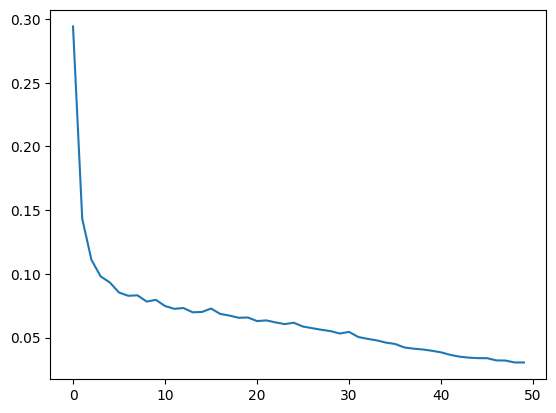

In [47]:
plt.plot(history.history["loss"], label="Training Loss")
plt.show()

In [49]:
i = images.as_numpy_iterator()

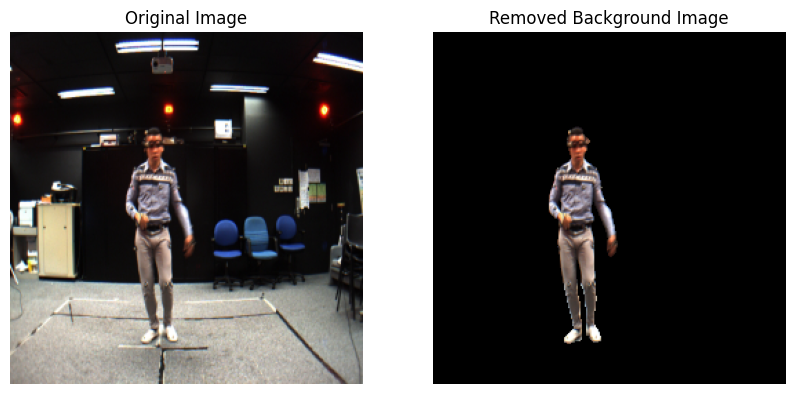

In [56]:
image = i.next()

predicted_mask = model.predict(np.expand_dims(image,axis=0),verbose=0)
predicted_mask = predicted_mask[0]
binary_mask = (predicted_mask > 0.3).astype(np.uint8)
foreground = image * binary_mask

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(foreground)
axes[1].set_title("Removed Background Image")
axes[1].axis("off")

plt.show()